# Libraries and Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
batch_size = 32
img_height = 128
img_width = 128

# Data Preprocessing

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantImages",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "PlantImages",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


# EDA

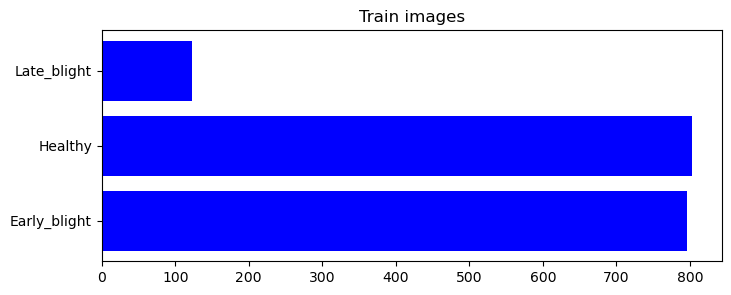

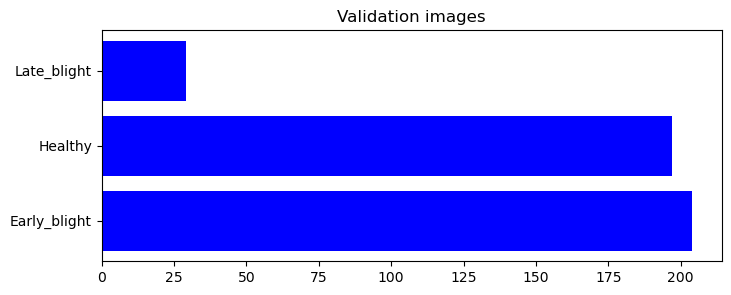

In [5]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['Early_blight', 'Healthy', 'Late_blight']
    
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

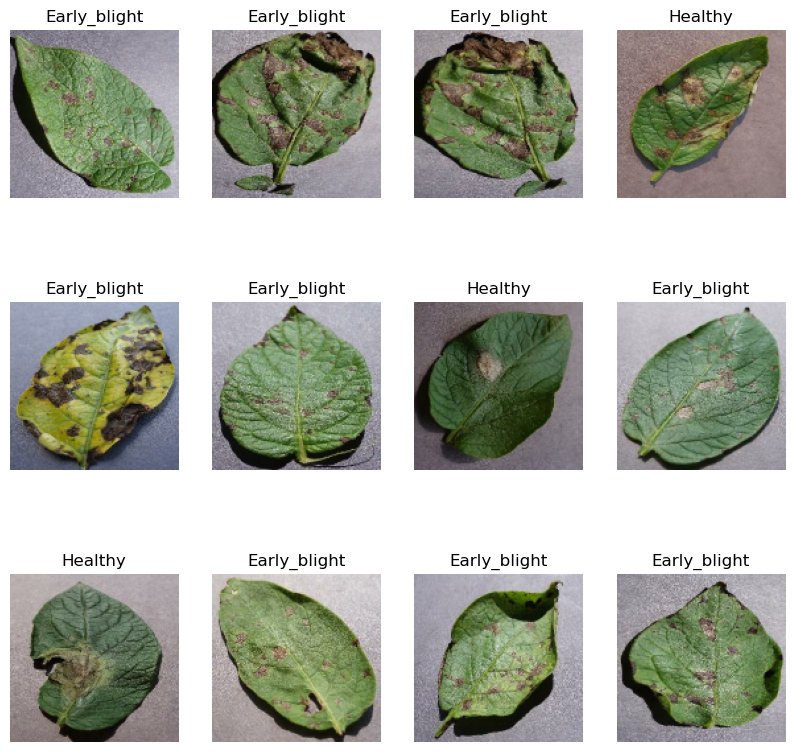

In [6]:
class_names = ['Early_blight', 'Healthy', 'Late_blight']  

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


# Model Training

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = 3
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[earlystop_callback])

Epoch 1/20
54/54 [==============================] - 5s 89ms/step - loss: 0.7710 - accuracy: 0.6278 - val_loss: 0.4045 - val_accuracy: 0.8558
Epoch 2/20
54/54 [==============================] - 4s 79ms/step - loss: 0.3857 - accuracy: 0.8513 - val_loss: 0.2823 - val_accuracy: 0.8814
Epoch 3/20
54/54 [==============================] - 4s 73ms/step - loss: 0.2932 - accuracy: 0.8879 - val_loss: 0.2313 - val_accuracy: 0.9116
Epoch 4/20
54/54 [==============================] - 4s 72ms/step - loss: 0.1948 - accuracy: 0.9367 - val_loss: 0.1682 - val_accuracy: 0.9419
Epoch 5/20
54/54 [==============================] - 4s 73ms/step - loss: 0.2201 - accuracy: 0.9170 - val_loss: 0.2978 - val_accuracy: 0.8837
Epoch 6/20
54/54 [==============================] - 4s 72ms/step - loss: 0.1566 - accuracy: 0.9483 - val_loss: 0.2008 - val_accuracy: 0.9302
Epoch 7/20
54/54 [==============================] - 4s 72ms/step - loss: 0.1409 - accuracy: 0.9506 - val_loss: 0.1534 - val_accuracy: 0.9349
Epoch 8/20
54

# Model Evaluation

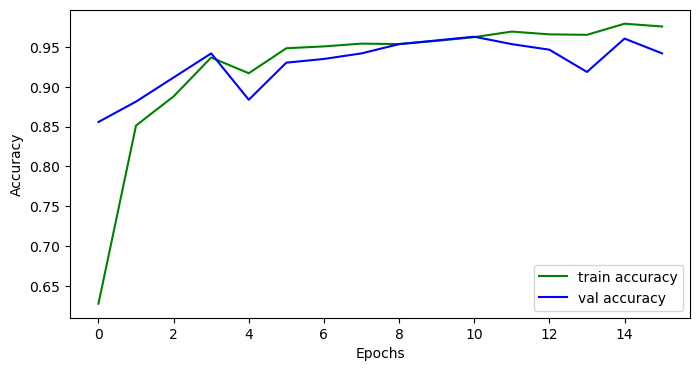

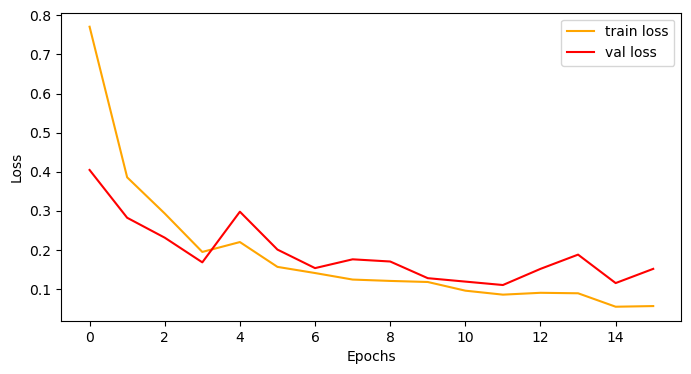

In [9]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

14/14 [==============================] - 0s 20ms/step - loss: 0.1515 - accuracy: 0.9419
validation accuracy : 0.94
validation loss : 0.15


In [11]:
y_pred = []  
y_true = []  

for image_batch, label_batch in val_ds:   
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 43ms/step


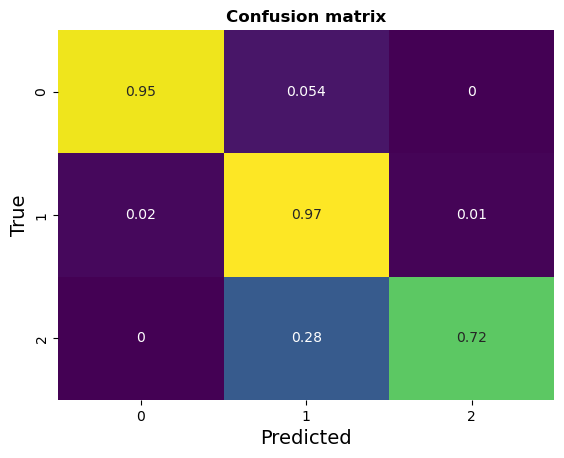

In [12]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [13]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       204
           1       0.91      0.97      0.94       197
           2       0.91      0.72      0.81        29

    accuracy                           0.94       430
   macro avg       0.93      0.88      0.90       430
weighted avg       0.94      0.94      0.94       430



# Post Processing

Image 1 to predict


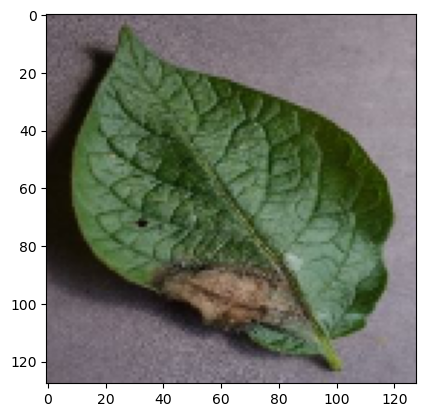

Actual label: Healthy
1/1 [==============================] - 0s 11ms/step
Predicted label: Healthy
------------------------------
Image 2 to predict


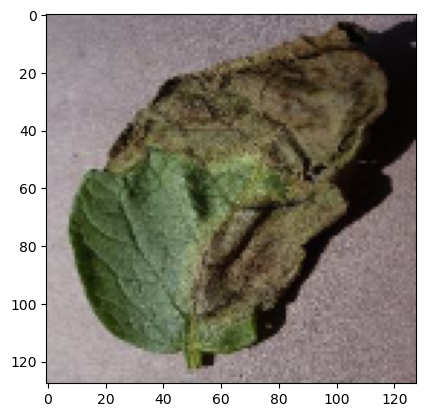

Actual label: Healthy
1/1 [==============================] - 0s 14ms/step
Predicted label: Healthy
------------------------------
Image 3 to predict


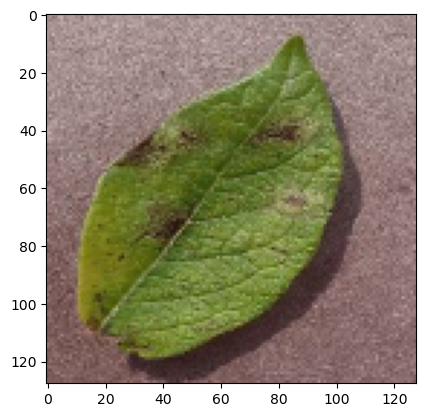

Actual label: Healthy
1/1 [==============================] - 0s 13ms/step
Predicted label: Healthy
------------------------------
Image 4 to predict


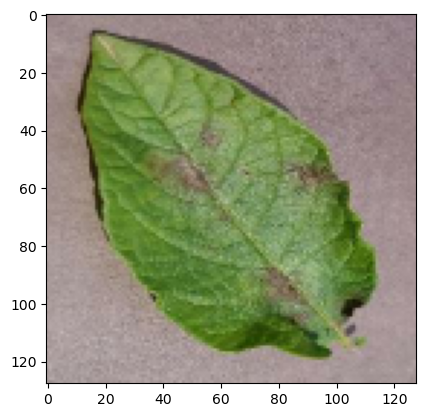

Actual label: Healthy
1/1 [==============================] - 0s 13ms/step
Predicted label: Healthy
------------------------------
Image 5 to predict


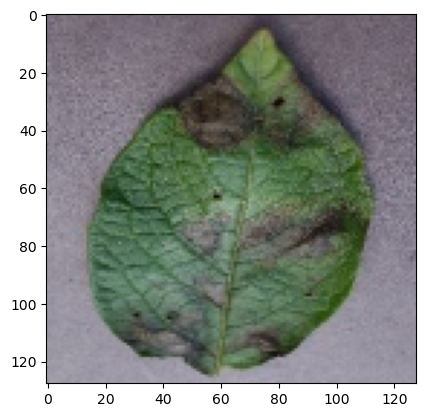

Actual label: Healthy
1/1 [==============================] - 0s 11ms/step
Predicted label: Healthy
------------------------------
Image 6 to predict


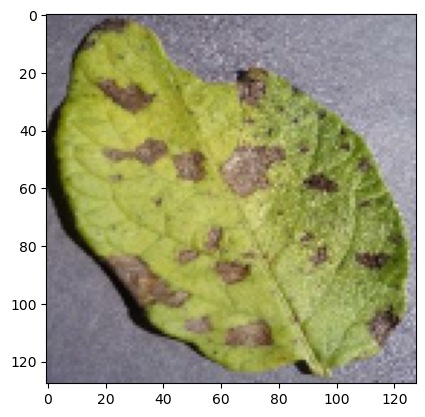

Actual label: Early_blight
1/1 [==============================] - 0s 13ms/step
Predicted label: Early_blight
------------------------------
Image 7 to predict


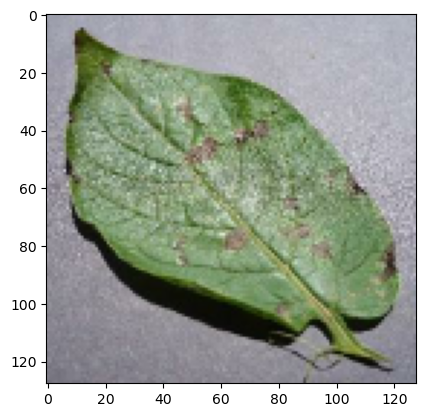

Actual label: Early_blight
1/1 [==============================] - 0s 9ms/step
Predicted label: Early_blight
------------------------------
Image 8 to predict


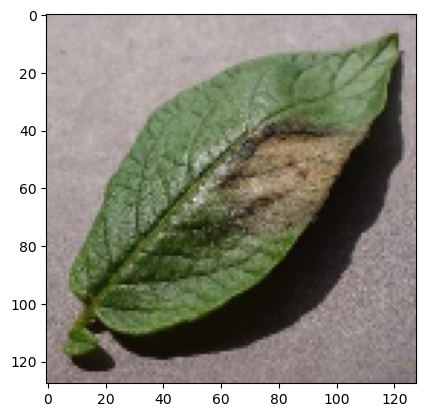

Actual label: Healthy
1/1 [==============================] - 0s 9ms/step
Predicted label: Healthy
------------------------------
Image 9 to predict


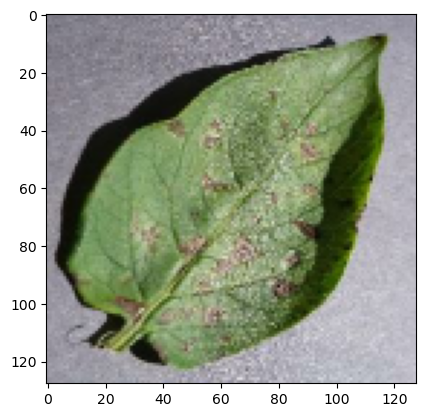

Actual label: Early_blight
1/1 [==============================] - 0s 9ms/step
Predicted label: Early_blight
------------------------------
Image 10 to predict


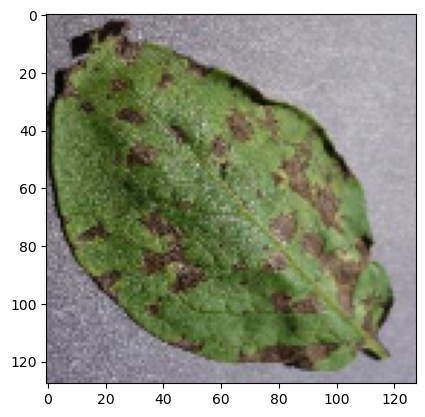

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 11 to predict


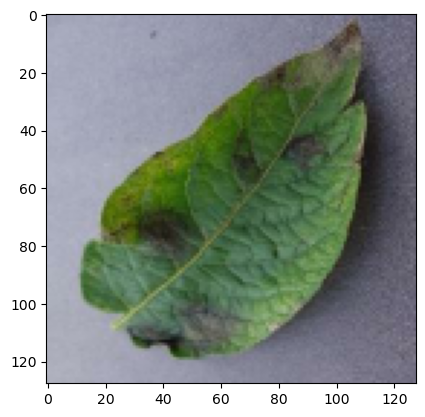

Actual label: Healthy
1/1 [==============================] - 0s 9ms/step
Predicted label: Healthy
------------------------------
Image 12 to predict


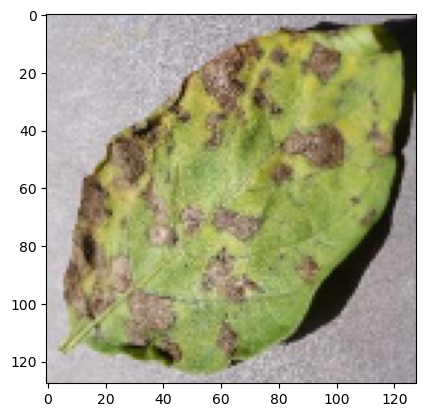

Actual label: Early_blight
1/1 [==============================] - 0s 9ms/step
Predicted label: Early_blight
------------------------------
Image 13 to predict


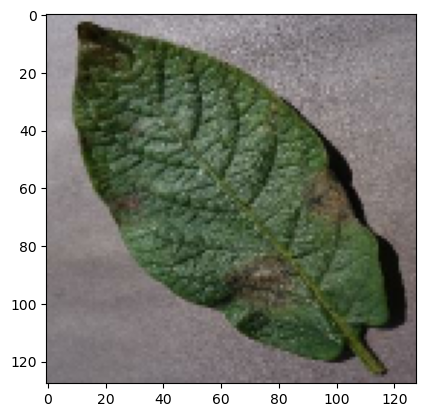

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 14 to predict


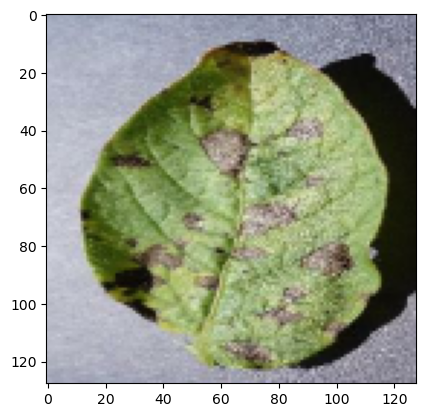

Actual label: Early_blight
1/1 [==============================] - 0s 11ms/step
Predicted label: Early_blight
------------------------------
Image 15 to predict


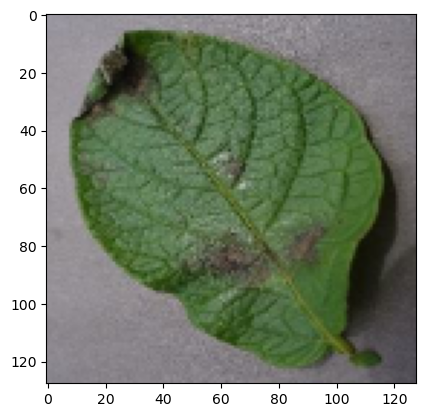

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 16 to predict


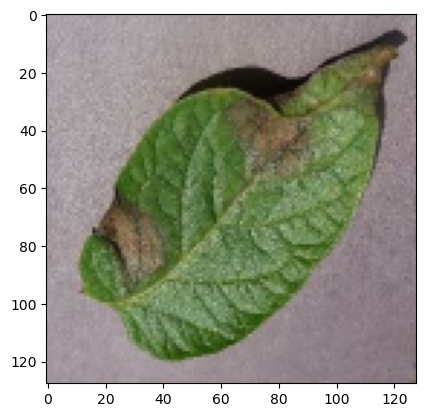

Actual label: Healthy
1/1 [==============================] - 0s 13ms/step
Predicted label: Healthy
------------------------------
Image 17 to predict


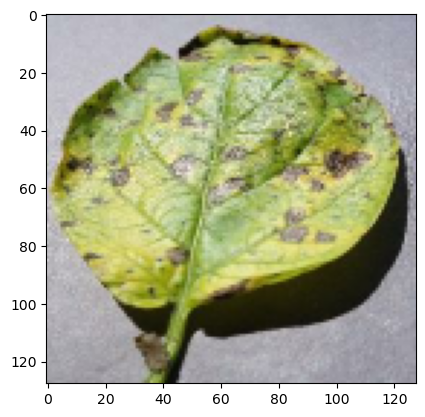

Actual label: Early_blight
1/1 [==============================] - 0s 9ms/step
Predicted label: Early_blight
------------------------------
Image 18 to predict


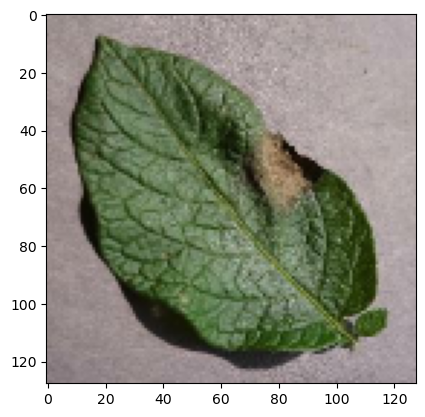

Actual label: Healthy
1/1 [==============================] - 0s 9ms/step
Predicted label: Healthy
------------------------------
Image 19 to predict


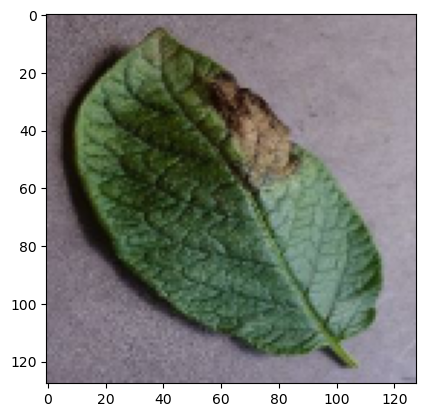

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 20 to predict


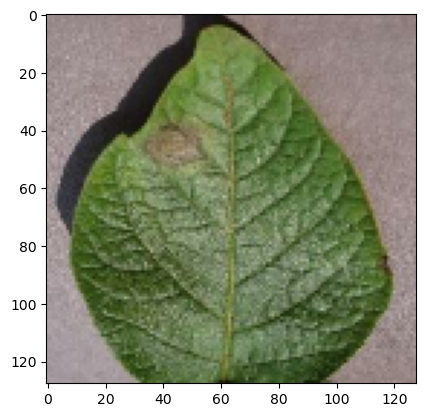

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 21 to predict


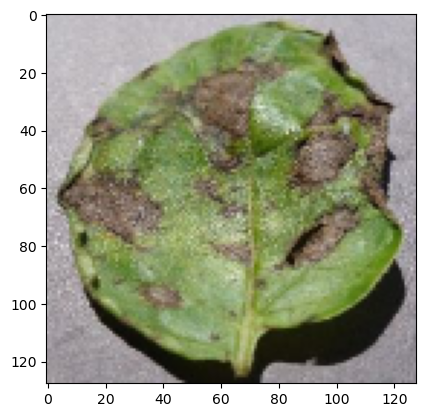

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 22 to predict


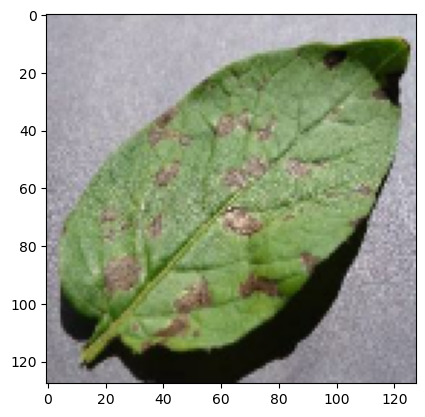

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 23 to predict


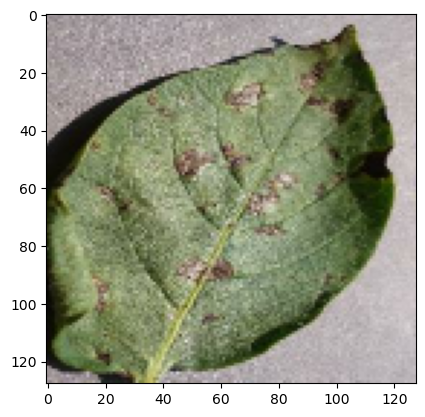

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 24 to predict


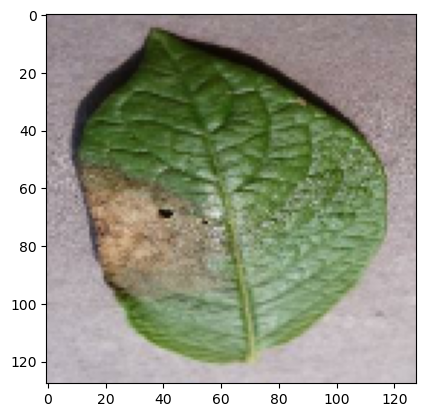

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 25 to predict


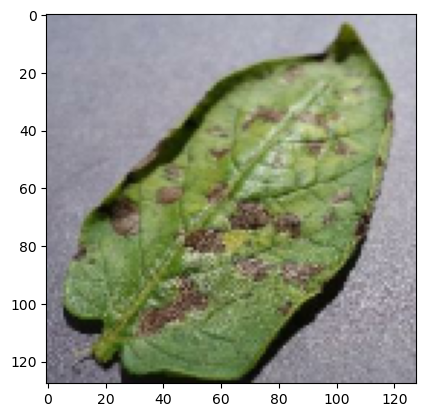

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 26 to predict


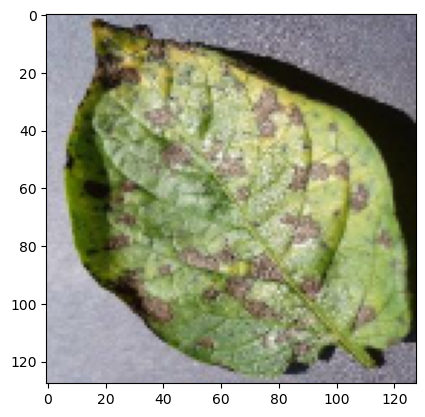

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 27 to predict


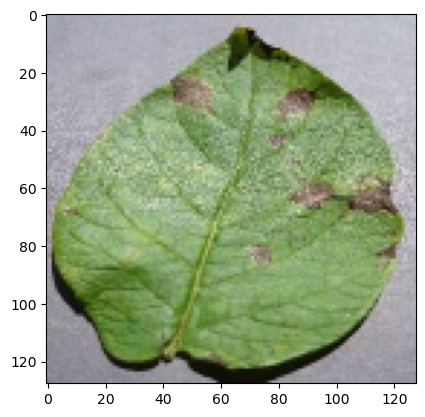

Actual label: Early_blight
1/1 [==============================] - 0s 10ms/step
Predicted label: Early_blight
------------------------------
Image 28 to predict


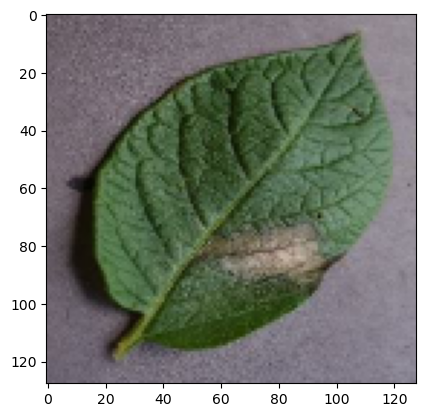

Actual label: Healthy
1/1 [==============================] - 0s 12ms/step
Predicted label: Healthy
------------------------------
Image 29 to predict


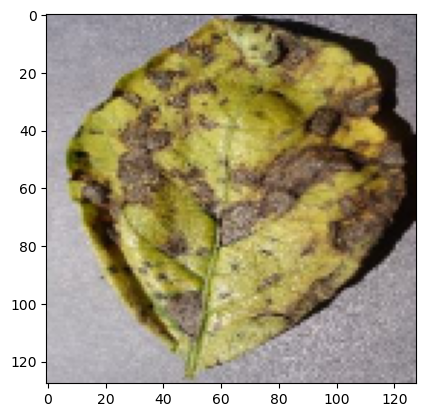

Actual label: Early_blight
1/1 [==============================] - 0s 9ms/step
Predicted label: Early_blight
------------------------------
Image 30 to predict


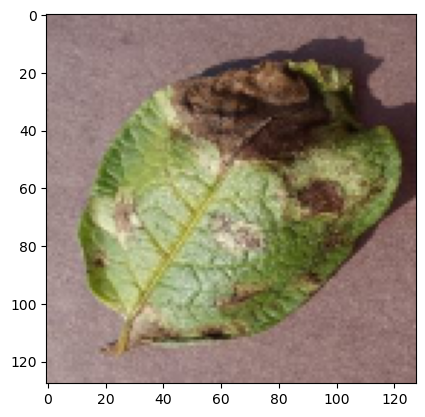

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------
Image 31 to predict


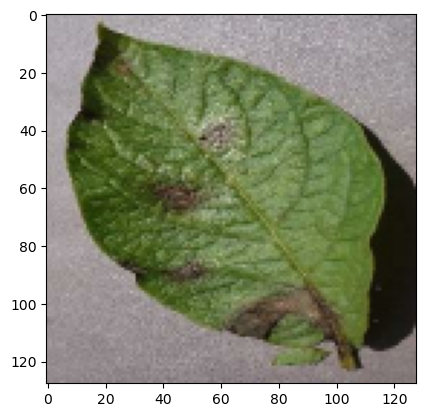

Actual label: Healthy
1/1 [==============================] - 0s 11ms/step
Predicted label: Healthy
------------------------------
Image 32 to predict


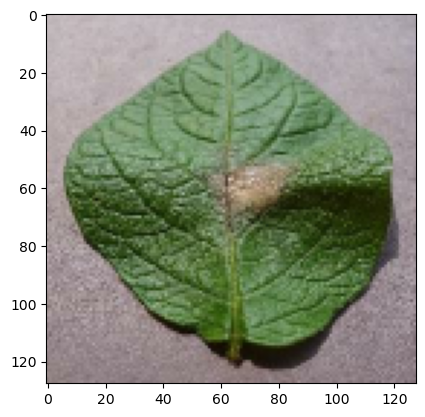

Actual label: Healthy
1/1 [==============================] - 0s 10ms/step
Predicted label: Healthy
------------------------------


In [18]:
import matplotlib.pyplot as plt

for images_batch, labels_batch in val_ds.take(1):
    for i in range(len(images_batch)):
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()

        print(f"Image {i + 1} to predict")
        plt.imshow(image)
        plt.show()

        print("Actual label:", class_names[label])

        batch_prediction = model.predict(np.expand_dims(images_batch[i], axis=0))
        predicted_label = np.argmax(batch_prediction)
        print("Predicted label:", class_names[predicted_label])
        print("-" * 30)
